#  Compare Outputs from GAN, VAE, and Diffusion Models

# VAE Implementation and Analysis

In [1]:
# VAE for ECG-like anomaly detection

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
# Synthetic ECG-like signal generator

def generate_ecg_like(n_samples=5000, length=140, anomaly_ratio=0.1, seed=42):
    rng = np.random.default_rng(seed)
    t = np.linspace(0, 1, length)

    # Normal signals: sine wave with small noise
    normals = []
    for _ in range(int(n_samples * (1 - anomaly_ratio))):
        freq = rng.uniform(4, 6)           # pseudo heart rate
        phase = rng.uniform(0, 2 * np.pi)
        signal = np.sin(2 * np.pi * freq * t + phase)
        signal += rng.normal(0, 0.05, size=length)  # small noise
        normals.append(signal)

    # Anomalies: distorted, shifted, spiky
    anomalies = []
    for _ in range(int(n_samples * anomaly_ratio)):
        freq = rng.uniform(2, 10)
        phase = rng.uniform(0, 2 * np.pi)
        signal = np.sin(2 * np.pi * freq * t + phase)
        signal *= rng.uniform(0.3, 1.5)  # amplitude change
        signal += rng.normal(0, 0.2, size=length)  # larger noise

        # occasional spike
        if rng.random() < 0.5:
            idx = rng.integers(10, length - 10)
            signal[idx:idx+3] += rng.uniform(1, 3)
        anomalies.append(signal)

    X = np.vstack([normals, anomalies]).astype(np.float32)
    y = np.hstack([np.zeros(len(normals)), np.ones(len(anomalies))]).astype(int)

    return X, y

X, y = generate_ecg_like(n_samples=5000, length=140, anomaly_ratio=0.2)

print("Data shape:", X.shape)
print("Labels distribution:", np.bincount(y))

Data shape: (5000, 140)
Labels distribution: [4000 1000]


In [3]:
# Train VAE only on normal data

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train = X_scaled[y == 0]   # normal only for training
X_test = X_scaled            # full for evaluation
y_test = y

X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)

input_dim = X_train.shape[1]
input_dim

140

In [4]:
# A simple fully connected VAE for 1D sequences

class VAE(nn.Module):
    def __init__(self, input_dim=140, latent_dim=8, hidden_dim=64):
        super().__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        x_recon = self.fc3(h)
        return x_recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

def vae_loss(x, x_recon, mu, logvar):
    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(x_recon, x, reduction='mean')
    # KL divergence
    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld, recon_loss, kld

vae = VAE(input_dim=input_dim, latent_dim=8, hidden_dim=64).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

Epoch 01 | Loss: 1.0128
Epoch 02 | Loss: 0.9753
Epoch 03 | Loss: 0.9092
Epoch 04 | Loss: 0.8294
Epoch 05 | Loss: 0.7823
Epoch 06 | Loss: 0.7503
Epoch 07 | Loss: 0.7402
Epoch 08 | Loss: 0.7349
Epoch 09 | Loss: 0.7337
Epoch 10 | Loss: 0.7227
Epoch 11 | Loss: 0.7168
Epoch 12 | Loss: 0.7119
Epoch 13 | Loss: 0.7056
Epoch 14 | Loss: 0.7029
Epoch 15 | Loss: 0.7005
Epoch 16 | Loss: 0.6885
Epoch 17 | Loss: 0.6864
Epoch 18 | Loss: 0.6873
Epoch 19 | Loss: 0.6893
Epoch 20 | Loss: 0.6831
Epoch 21 | Loss: 0.6865
Epoch 22 | Loss: 0.6748
Epoch 23 | Loss: 0.6809
Epoch 24 | Loss: 0.6825
Epoch 25 | Loss: 0.6750
Epoch 26 | Loss: 0.6798
Epoch 27 | Loss: 0.6753
Epoch 28 | Loss: 0.6768
Epoch 29 | Loss: 0.6715
Epoch 30 | Loss: 0.6717


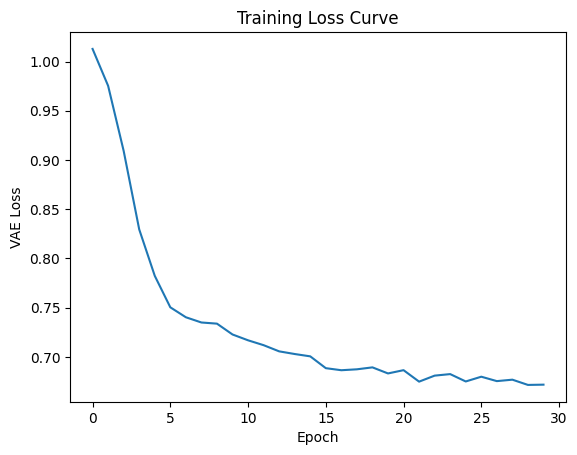

In [5]:
# Train the VAE 

def train_vae(model, X_train, epochs=30, batch_size=128):
    model.train()
    n = X_train.shape[0]
    losses = []
    for epoch in range(1, epochs + 1):
        perm = torch.randperm(n)
        epoch_loss = 0.0

        for i in range(0, n, batch_size):
            idx = perm[i:i+batch_size]
            batch = X_train[idx]

            optimizer.zero_grad()
            x_recon, mu, logvar = model(batch)
            loss, recon_loss, kld = vae_loss(batch, x_recon, mu, logvar)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * len(batch)

        epoch_loss /= n
        losses.append(epoch_loss)
        print(f"Epoch {epoch:02d} | Loss: {epoch_loss:.4f}")

    return losses

losses = train_vae(vae, X_train_t, epochs=30, batch_size=128)

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("VAE Loss")
plt.title("Training Loss Curve")
plt.show()

In [6]:
# Use reconstruction error as an anomaly score: higher error → likely anomaly

vae.eval()
with torch.no_grad():
    X_test_recon, _, _ = vae(X_test_t)

X_test_np = X_test_t.cpu().numpy()
X_recon_np = X_test_recon.cpu().numpy()

recon_errors = np.mean((X_test_np - X_recon_np) ** 2, axis=1)
recon_errors[:10]

array([0.20199344, 0.46028584, 1.1948763 , 0.36017573, 0.53360564,
       0.58704746, 0.16860557, 0.3245499 , 0.51524156, 0.1510522 ],
      dtype=float32)

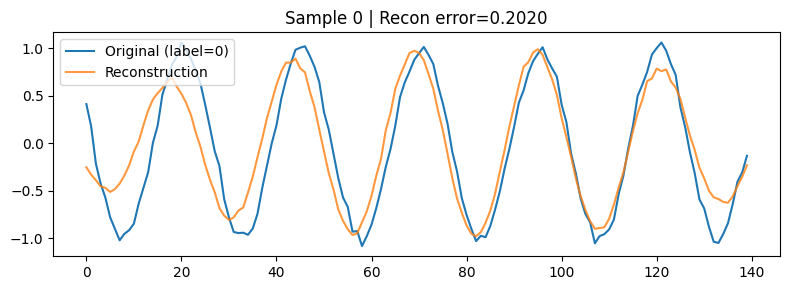

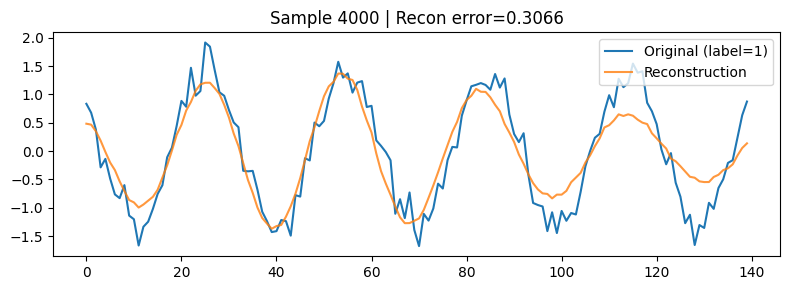

In [7]:
# Visualize a few reconstructions

def plot_reconstruction(idx):
    original = X_test_np[idx]
    recon = X_recon_np[idx]

    # Inverse scaling for interpretability
    orig_inv = scaler.inverse_transform(original.reshape(1, -1)).flatten()
    recon_inv = scaler.inverse_transform(recon.reshape(1, -1)).flatten()

    plt.figure(figsize=(8, 3))
    plt.plot(orig_inv, label=f"Original (label={y_test[idx]})")
    plt.plot(recon_inv, label="Reconstruction", alpha=0.8)
    plt.title(f"Sample {idx} | Recon error={recon_errors[idx]:.4f}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Show a normal example and an anomalous example
normal_idx = np.where(y_test == 0)[0][0]
anomaly_idx = np.where(y_test == 1)[0][0]

plot_reconstruction(normal_idx)
plot_reconstruction(anomaly_idx)

In [8]:
# Quantitative anomaly detection performance

# Simple thresholding based on percentile of errors on train normals

with torch.no_grad():
    X_train_recon, _, _ = vae(X_train_t)
X_train_np = X_train_t.cpu().numpy()
X_train_recon_np = X_train_recon.cpu().numpy()
train_errors = np.mean((X_train_np - X_train_recon_np) ** 2, axis=1)

threshold = np.percentile(train_errors, 95)  # 95th percentile
print("Threshold:", threshold)

y_pred = (recon_errors > threshold).astype(int)

print(classification_report(y_test, y_pred, target_names=["normal", "anomaly"]))
print("ROC-AUC:", roc_auc_score(y_test, recon_errors))

Threshold: 0.79224354
              precision    recall  f1-score   support

      normal       0.92      0.95      0.93      4000
     anomaly       0.75      0.65      0.70      1000

    accuracy                           0.89      5000
   macro avg       0.83      0.80      0.81      5000
weighted avg       0.88      0.89      0.88      5000

ROC-AUC: 0.9001778749999999


VAE:

- Stable training, well‑behaved latent space
- Good for anomaly detection, representation learning, interpolation
Output quality:
- Often blurrier than GANs/diffusion due to pixel‑wise reconstruction + Gaussian assumptions
Diversity:
- Latent sampling gives diversity, but sometimes mode‑averaging → smoother outputs

# GAN Implementation and Training

In [9]:
# Create an Imbalanced Dataset
# We’ll create:
# - Normal class (majority) → sine waves
# - Minority class (rare) → distorted waves
# GAN will learn to generate minority samples

In [10]:
def generate_imbalanced_data(n_major=2000, n_minor=200, length=140, seed=42):
    rng = np.random.default_rng(seed)
    t = np.linspace(0, 1, length)

    # Majority class (normal)
    majority = []
    for _ in range(n_major):
        freq = rng.uniform(4, 6)
        signal = np.sin(2 * np.pi * freq * t)
        signal += rng.normal(0, 0.05, size=length)
        majority.append(signal)

    # Minority class (anomalous)
    minority = []
    for _ in range(n_minor):
        freq = rng.uniform(2, 10)
        signal = np.sin(2 * np.pi * freq * t)
        signal *= rng.uniform(0.5, 1.5)
        signal += rng.normal(0, 0.2, size=length)
        minority.append(signal)

    return np.array(majority), np.array(minority)

majority, minority = generate_imbalanced_data()
print("Majority:", majority.shape)
print("Minority:", minority.shape)

Majority: (2000, 140)
Minority: (200, 140)


In [11]:
# Define Generator and Discriminator

signal_dim = majority.shape[1]
latent_dim = 32

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, signal_dim)
        )

    def forward(self, z):
        return self.net(z)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(signal_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [12]:
# Instantiate models

G = Generator().to(device)
D = Discriminator().to(device)

In [13]:
# Prepare Minority Data for GAN Training

minority_t = torch.tensor(minority, dtype=torch.float32).to(device)
batch_size = 64

In [15]:
# GAN Training Loop

import torch.optim as optim

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.0002)
optimizer_D = optim.Adam(D.parameters(), lr=0.0002)

epochs = 2000
losses_G, losses_D = [], []

for epoch in range(epochs):
    
    # Train Discriminator
    
    idx = np.random.randint(0, minority_t.shape[0], batch_size)
    real = minority_t[idx]

    z = torch.randn(batch_size, latent_dim).to(device)
    fake = G(z)

    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    D_real = D(real)
    D_fake = D(fake.detach())

    loss_D_real = criterion(D_real, real_labels)
    loss_D_fake = criterion(D_fake, fake_labels)
    loss_D = loss_D_real + loss_D_fake

    optimizer_D.zero_grad()
    loss_D.backward()
    optimizer_D.step()

    
    # Train Generator
    
    z = torch.randn(batch_size, latent_dim).to(device)
    fake = G(z)
    D_fake = D(fake)

    loss_G = criterion(D_fake, real_labels)

    optimizer_G.zero_grad()
    loss_G.backward()
    optimizer_G.step()

    # Logging
    losses_G.append(loss_G.item())
    losses_D.append(loss_D.item())

    if epoch % 200 == 0:
        print(f"Epoch {epoch} | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")

Epoch 0 | D Loss: 1.3830 | G Loss: 0.7152
Epoch 200 | D Loss: 0.6656 | G Loss: 1.4763
Epoch 400 | D Loss: 0.1431 | G Loss: 3.6509
Epoch 600 | D Loss: 0.1520 | G Loss: 2.4464
Epoch 800 | D Loss: 0.0723 | G Loss: 3.5126
Epoch 1000 | D Loss: 0.0541 | G Loss: 4.9027
Epoch 1200 | D Loss: 0.0312 | G Loss: 6.1579
Epoch 1400 | D Loss: 0.0227 | G Loss: 5.9501
Epoch 1600 | D Loss: 0.0267 | G Loss: 5.4183
Epoch 1800 | D Loss: 0.0273 | G Loss: 4.6517


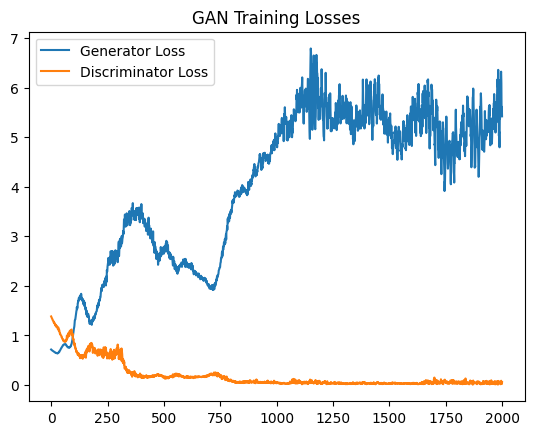

In [16]:
# Plot Training Losses

plt.plot(losses_G, label="Generator Loss")
plt.plot(losses_D, label="Discriminator Loss")
plt.legend()
plt.title("GAN Training Losses")
plt.show()

In [17]:
# Generate Synthetic Minority Samples

def generate_samples(n=10):
    z = torch.randn(n, latent_dim).to(device)
    samples = G(z).detach().cpu().numpy()
    return samples

synthetic = generate_samples(20)
synthetic.shape

(20, 140)

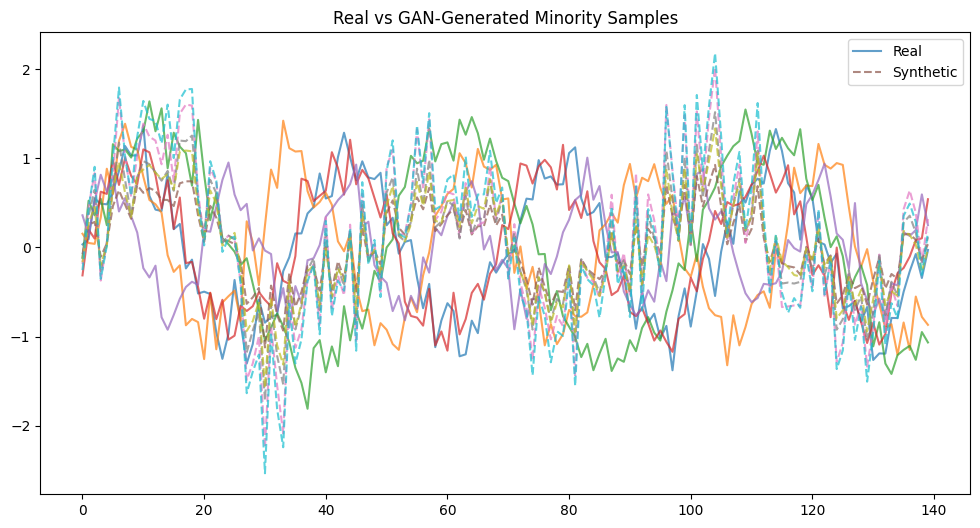

In [18]:
# Visualize GAN‑Generated Samples

plt.figure(figsize=(12, 6))

for i in range(5):
    plt.plot(minority[i], alpha=0.7, label="Real" if i == 0 else "")

for i in range(5):
    plt.plot(synthetic[i], alpha=0.7, linestyle="--", label="Synthetic" if i == 0 else "")

plt.title("Real vs GAN-Generated Minority Samples")
plt.legend()
plt.show()

In [19]:
# Use GAN Samples to Balance Dataset

balanced_minority = np.vstack([minority, synthetic])
print("Balanced minority size:", balanced_minority.shape)

Balanced minority size: (220, 140)


✔ Created an imbalanced dataset
✔ Built Generator + Discriminator
✔ Trained a GAN
✔ Generated synthetic minority samples
✔ Visualized quality & diversity
✔ Balanced the dataset with GAN outputs

# Diffusion Model Setup and Comprehensive Comparison

In [20]:
# Generate simple “patient trajectory” data
# Each trajectory is a 1D sequence of length T:
# - Some patients: gradual increase (e.g., worsening marker)
# - Others: stable or mild trend
# We’ll treat all as training data for the generative model.

def generate_patient_trajectories(n_samples=4000, length=50, seed=42):
    rng = np.random.default_rng(seed)
    t = np.linspace(0, 1, length)

    X = []
    for _ in range(n_samples):
        # baseline value
        base = rng.uniform(0.0, 1.0)
        # slope (trend)
        slope = rng.uniform(-0.5, 1.0)
        # curvature
        curve = rng.uniform(-0.5, 0.5)

        traj = base + slope * t + curve * (t - 0.5) ** 2
        traj += rng.normal(0, 0.05, size=length)  # small noise
        X.append(traj)

    X = np.array(X, dtype=np.float32)
    return X

X_traj = generate_patient_trajectories()
print("Trajectory data shape:", X_traj.shape)

Trajectory data shape: (4000, 50)


In [21]:
# Normalise to zero mean, until variance: 

mean = X_traj.mean()
std = X_traj.std()
X_norm = (X_traj - mean) / std

X_torch = torch.tensor(X_norm, dtype=torch.float32).to(device)
traj_len = X_torch.shape[1]
traj_len

50

In [22]:
# Diffusion Noise Schedule (DDPM‑style)
# We’ll use a simple linear beta schedule.

T = 100  # number of diffusion steps

beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T).to(device)

alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)  # \bar{alpha}_t

In [23]:
def q_sample(x0, t, noise=None):
    """
    Sample x_t ~ q(x_t | x0)
    x0: (batch, traj_len)
    t: (batch,) time indices
    """
    if noise is None:
        noise = torch.randn_like(x0)

    alpha_bar_t = alpha_bars[t].unsqueeze(-1)  # (batch, 1)
    return torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * noise

In [24]:
# Denoising Network (ε‑Predictor)
# A small MLP that takes (x_t,t) and predicts the noise \epsilon

class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.lin1 = nn.Linear(1, dim)
        self.lin2 = nn.Linear(dim, dim)

    def forward(self, t):
        # t: (batch,) scalar timestep
        t = t.float().unsqueeze(-1) / T
        x = torch.relu(self.lin1(t))
        x = torch.relu(self.lin2(x))
        return x


class DenoiseModel(nn.Module):
    def __init__(self, traj_len, hidden_dim=128, time_dim=32):
        super().__init__()
        self.time_mlp = TimeEmbedding(time_dim)

        self.fc1 = nn.Linear(traj_len + time_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, traj_len)

    def forward(self, x_t, t):
        # x_t: (batch, traj_len)
        # t: (batch,)
        t_embed = self.time_mlp(t)           # (batch, time_dim)
        x = torch.cat([x_t, t_embed], dim=1) # (batch, traj_len + time_dim)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        eps_pred = self.fc3(x)
        return eps_pred

model = DenoiseModel(traj_len=traj_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Epoch 01 | Loss: 0.9785
Epoch 02 | Loss: 0.8571
Epoch 03 | Loss: 0.6688
Epoch 04 | Loss: 0.5477
Epoch 05 | Loss: 0.4653
Epoch 06 | Loss: 0.4109
Epoch 07 | Loss: 0.3607
Epoch 08 | Loss: 0.3306
Epoch 09 | Loss: 0.3080
Epoch 10 | Loss: 0.2945
Epoch 11 | Loss: 0.2875
Epoch 12 | Loss: 0.2869
Epoch 13 | Loss: 0.2744
Epoch 14 | Loss: 0.2671
Epoch 15 | Loss: 0.2755
Epoch 16 | Loss: 0.2717
Epoch 17 | Loss: 0.2668
Epoch 18 | Loss: 0.2678
Epoch 19 | Loss: 0.2704
Epoch 20 | Loss: 0.2677
Epoch 21 | Loss: 0.2641
Epoch 22 | Loss: 0.2738
Epoch 23 | Loss: 0.2668
Epoch 24 | Loss: 0.2743
Epoch 25 | Loss: 0.2649
Epoch 26 | Loss: 0.2655
Epoch 27 | Loss: 0.2628
Epoch 28 | Loss: 0.2649
Epoch 29 | Loss: 0.2639
Epoch 30 | Loss: 0.2572


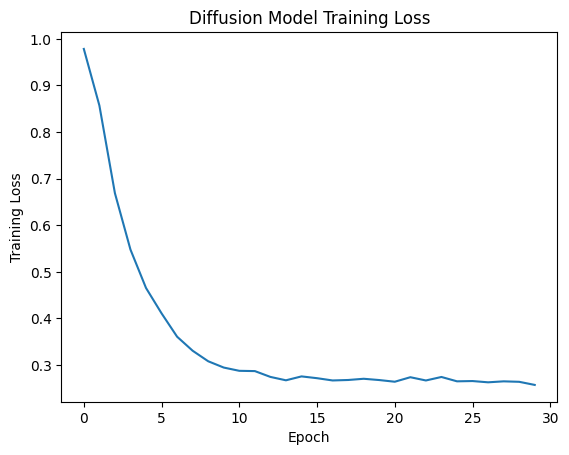

In [25]:
# Train the Diffusion Model
# Training objective: predict the true noise \epsilon added at step t.

def train_diffusion(model, X, epochs=30, batch_size=128):
    n = X.shape[0]
    all_losses = []

    for epoch in range(1, epochs + 1):
        perm = torch.randperm(n)
        epoch_loss = 0.0

        for i in range(0, n, batch_size):
            idx = perm[i:i+batch_size]
            x0 = X[idx]

            # sample random timesteps
            t = torch.randint(0, T, (x0.shape[0],), device=device).long()
            noise = torch.randn_like(x0)

            x_t = q_sample(x0, t, noise=noise)
            eps_pred = model(x_t, t)

            loss = F.mse_loss(eps_pred, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * x0.size(0)

        epoch_loss /= n
        all_losses.append(epoch_loss)
        print(f"Epoch {epoch:02d} | Loss: {epoch_loss:.4f}")

    return all_losses

diff_losses = train_diffusion(model, X_torch, epochs=30, batch_size=128)

plt.plot(diff_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Diffusion Model Training Loss")
plt.show()

In [26]:
# Reverse Diffusion: Sampling New Trajectorie

@torch.no_grad()
def p_sample(model, x_t, t):
    """
    Single reverse step: x_t -> x_{t-1}
    t: scalar int
    """
    beta_t = betas[t]
    alpha_t = alphas[t]
    alpha_bar_t = alpha_bars[t]

    eps_theta = model(x_t, torch.full((x_t.shape[0],), t, device=device, dtype=torch.long))

    # DDPM mean
    coef1 = 1 / torch.sqrt(alpha_t)
    coef2 = (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)
    mean = coef1 * (x_t - coef2 * eps_theta)

    if t > 0:
        z = torch.randn_like(x_t)
        sigma_t = torch.sqrt(beta_t)
        x_prev = mean + sigma_t * z
    else:
        x_prev = mean

    return x_prev


@torch.no_grad()
def sample_trajectories(model, n_samples=10):
    x_t = torch.randn(n_samples, traj_len, device=device)
    for t in reversed(range(T)):
        x_t = p_sample(model, x_t, t)
    return x_t

samples = sample_trajectories(model, n_samples=10)
samples_np = samples.cpu().numpy()

In [27]:
# Invert normalization for interpretability:

samples_denorm = samples_np * std + mean
X_denorm = X_norm * std + mean

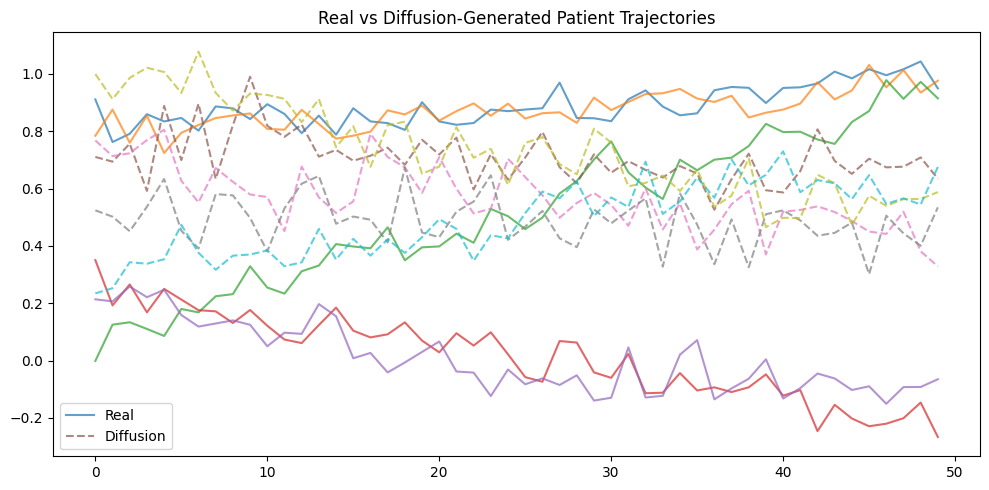

In [28]:
# Visualize Real vs Diffusion‑Generated Trajectories

plt.figure(figsize=(10, 5))

for i in range(5):
    plt.plot(X_denorm[i], alpha=0.7, label="Real" if i == 0 else "")

for i in range(5):
    plt.plot(samples_denorm[i], alpha=0.7, linestyle="--", label="Diffusion" if i == 0 else "")

plt.title("Real vs Diffusion-Generated Patient Trajectories")
plt.legend()
plt.tight_layout()
plt.show()

Quality of Outputs

VAE
- Pros: Good at capturing overall structure and trends.
- Cons: Reconstructions and samples tend to be smoother, slightly blurry; extremes/spikes often under‑represented.

GAN
- Pros: Sharp, realistic samples; can reproduce detailed patterns and rare structures if trained well.
- Cons: Can be unstable; may overfit patterns and ignore some modes (mode collapse).

Diffusion
- Pros: Very high‑fidelity samples; captures subtle variability and smooth + noisy characteristics well.
- Cons: Sampling is slow (many steps), more complex to implement and tune than VAE.

Diversity and Mode Coverage

VAE
- Latent sampling gives diversity, but KL + reconstruction can lead to “averaging” → mid‑range behaviours more common than extremes.

GAN
- Potentially high quality but can miss modes (e.g., some trajectory shapes never generated).
- Diversity highly dependent on training stability and architecture.

Diffusion
- Typically excellent mode coverage; iterative denoising tends to explore a richer set of patterns.
- You’re likely to see a wide range of trends and shapes in generated trajectories.

Stability and Training Behaviour

VAE
- Most stable to train.
- Likely to converge smoothly with standard hyperparameters.

GAN
- Sensitive to learning rates, architecture, and loss balance between G and D.
- Mode collapse and oscillations are common.

Diffusion
- Training is relatively stable (simple noise‑prediction objective).
- Complexity moved to sampling process rather than training dynamics.

Applicability by Use Case

Anomaly Detection / Trajectory Modelling
- VAE: Strong candidate (reconstruction error, latent structure).
- Diffusion: Useful for high‑fidelity generative simulation and data augmentation.
- GAN: Can augment rare patterns, but less principled for density/anomaly scoring.

Data Augmentation for Imbalanced Time Series
- GAN & Diffusion: Good for generating synthetic minority patterns.
- Diffusion usually offers better diversity and fewer artifacts once implemented.

High‑fidelity Visual Content (e.g., marketing images)
- Diffusion (Stable Diffusion) dominates: controllable, diverse, high‑quality.
- GANs still strong in certain domains; VAEs usually lag in sharpness.


Computational Characteristics

VAE
- Training: Fast, single forward/backward.
- Sampling: Very fast (single pass).

GAN
- Training: Heavier (two networks, adversarial), but still single‑step samples.
- Sampling: Fast once trained.

Diffusion
- Training: Comparable to VAE per step, but can be longer (more data/steps).
- Sampling: Slowest (T iterative steps), though can be accelerated with fewer steps or improved samplers